<a href="https://colab.research.google.com/github/shinchacoffee/MNIST_practice/blob/main/MNIST_ze_stronki_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3            # how many times data is used
batch_size_train = 64   # number of samples per one gradient calc
batch_size_test = 1000  # number of samples per one test step (used as many times as needed to empty the test set)
learning_rate = 0.01    # multiplicator (can be a vector) of gradient result (the higher the more impact each step has)
momentum = 0.5          # memory coefficient of dampening oscillations (1 is equal to infinite memory time and 0 to no memory at all)
log_interval = 10       # ??????? how frequently logs are produced ?

random_seed = 1         # seed do rng
torch.backends.cudnn.enabled = True # cause fuck TPU
torch.manual_seed(random_seed)      # giving seed to torch

In [3]:
class asd:
  def __init__(self,x):
    self.x = x

  def __len__(self):
    return len(self.x)

  def __getitem__(self,idx):
    return self.x[idx]

y=asd(['asd1','asd2','asd3'])
print(y.x)
print(len(y))
print(y[1])

['asd1', 'asd2', 'asd3']
3
asd2


In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
for index, x in enumerate(train_loader):
  print(x[0][5].mean())
  print(index)
  break

for x in train_loader:
  print(x[0][5].mean())
  break
asd=enumerate(train_loader)

tensor(-0.1858)
0
tensor(-0.0542)


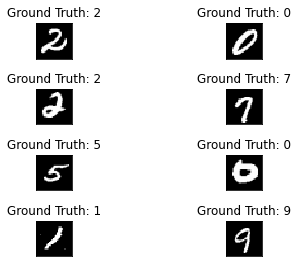

In [6]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(8):
  plt.subplot(4,2,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() #was super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [10]:
network.to('cuda')

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data,target=data.to('cuda'),target.to('cuda')
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')


In [13]:
for epoch in range(1, n_epochs + 1):
  train(epoch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306040
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.285255
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.311765
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.248175
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.273032
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.205897
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.133468
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.021585
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.890136
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.866923
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.852751
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.817114
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.624506
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.532222
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.720882
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.248820
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.133471
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.275914
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.005749
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.089448
Train Epoch: 1 [12800/60000 (

In [14]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data,target=data.to('cuda'),target.to('cuda')
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      ii=0
      for x,y,z in zip(pred.cpu().numpy(),target.cpu().numpy(),data.cpu().numpy()):
        if x != y:
          print(x[0],y,z.shape)
          plt.subplot(20,1,1+ii)
          plt.imshow(z[0], cmap='gray', interpolation='none')
          plt.title("truth: {} pred: {}".format(y,x))
          plt.xticks([])
          plt.yticks([])
          ii=ii+1
      break
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 6 (1, 28, 28)
3 7 (1, 28, 28)
9 7 (1, 28, 28)
3 2 (1, 28, 28)
9 8 (1, 28, 28)
4 9 (1, 28, 28)
2 7 (1, 28, 28)
4 8 (1, 28, 28)
2 8 (1, 28, 28)
9 8 (1, 28, 28)
0 7 (1, 28, 28)
8 3 (1, 28, 28)
4 9 (1, 28, 28)
2 8 (1, 28, 28)
9 7 (1, 28, 28)
9 3 (1, 28, 28)
0 6 (1, 28, 28)
4 9 (1, 28, 28)
3 2 (1, 28, 28)
2 3 (1, 28, 28)
2 3 (1, 28, 28)


ValueError: ignored

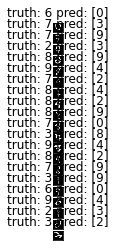

In [15]:
test()
#for epoch in range(1, n_epochs + 1):
#  train(epoch)
#  test()

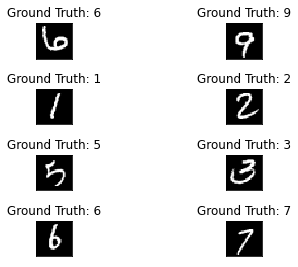

In [16]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(8):
  plt.subplot(4,2,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])